In [1]:
!pip3 install wandb duckduckgo_search -qq

In [96]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep
import wandb
import params

def search_images(term, max_images=20):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [165]:
def label_func(fname):
    return (fname.parent.parent/"labels")/f"{fname.stem}_mask.png"

def get_classes_per_image(mask_data, class_labels):
    unique = list(np.unique(mask_data))
    result_dict = {}
    for _class in class_labels.keys():
        result_dict[class_labels[_class]] = int(_class in unique)
    return result_dict

def _create_table(image_files, class_labels, image_labels, dataset_name):
    "Create a table with the dataset"
    table = wandb.Table(columns=["File_Name", "Images", "Dataset", "Labels"])
    
    for i, image_file in progress_bar(enumerate(image_files), total=len(image_files)):
        image = Image.open(image_file)
        class_in_image = image_labels[image_labels['Image'] == str(image_file).split('/')[-1]]['Label'].values[0]
        table.add_data(
            image_file.stem,
            wandb.Image(image),
            dataset_name,
            class_in_image
        )
        
    return table
        

In [3]:
urls = search_images('Lion photos', max_images=1)
urls[0]

Searching for 'Lion photos'


'http://1.bp.blogspot.com/-VbjhH3Upty4/Uyf29k57yGI/AAAAAAAAbu8/vm2KOpSXI58/s1600/African+Lion+Wallpapers+(6).jpg'

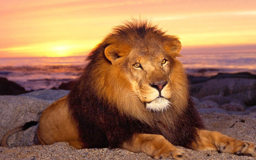

In [7]:
dest = 'Lion.jpg'
download_url(urls[0], dest, show_progress=False)


im = Image.open(dest)
im.to_thumb(256,256)

In [32]:
path = Path('Dataset/Lions')

In [16]:
%%time

searches = ['Lion','Lioness', 'Lion cubs']
path = Path('Big Cat Classification/Dataset/Lions')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} dark photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

CPU times: user 27 µs, sys: 10 µs, total: 37 µs
Wall time: 44.3 µs


In [34]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

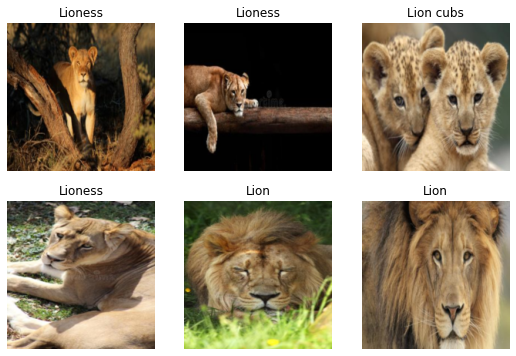

In [35]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [92]:
def _prepare_data(path):
    df = pd.DataFrame(columns = ['Image', 'Label'])
    for cl in ['Lion', 'Lioness', 'Lion cubs']:
        temp = []
        temp_df = pd.DataFrame(columns = ['Image', 'Label'])
        for i in range(len(list(get_image_files(path/cl)))):
            temp.append(str(list(get_image_files(path/cl))[i]).split('/')[-1])
        temp_df['Image'] = temp
        temp_df['Label'] = cl
        df = pd.concat([df, temp_df])
    return df

In [97]:
run = wandb.init(project=params.WANDB_PROJECT, entity=None, job_type="upload_lions_01")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [98]:
artifact = wandb.Artifact(params.RAW_DATA_AT, type="raw_data")

In [100]:
artifact.add_dir(path, name='lion_images')

wandb: Adding directory to artifact (./Dataset/Lions)... Done. 0.1s


In [106]:
image_files = get_image_files(path)

In [166]:
table = _create_table(image_files, params.LIONS_CLASSES, df, dataset_name='lions')

In [168]:
artifact.add(table, "eda_table")

ArtifactManifestEntry(path='eda_table.table.json', digest='VodQ9Kc+ByKQ9nRj886h6Q==', ref=None, birth_artifact_id=None, size=46633, extra={}, local_path='/root/.local/share/wandb/artifacts/staging/tmpmx6ax9rd')

In [169]:
run.log_artifact(artifact)
run.finish()

In [171]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.851050,1.171004,0.485714,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.663881,0.668150,0.285714,00:01
1,0.508469,0.563225,0.228571,00:01
2,0.373188,0.631209,0.228571,00:01
3,0.280075,0.689402,0.200000,00:01
4,0.219621,0.655881,0.171429,00:01
5,0.176619,0.632331,0.142857,00:01
6,0.146253,0.641296,0.142857,00:01
7,0.125928,0.636656,0.171429,00:01
8,0.107505,0.630985,0.171429,00:01
9,0.094258,0.632000,0.142857,00:01


In [173]:
interp = ClassificationInterpretation.from_learner(learn)

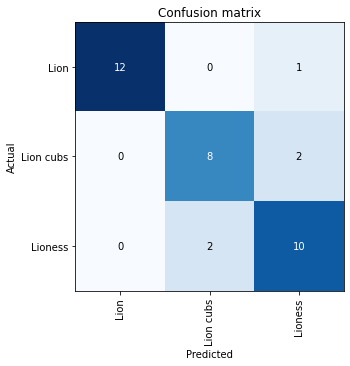

In [174]:
interp.plot_confusion_matrix(figsize=(5, 5))

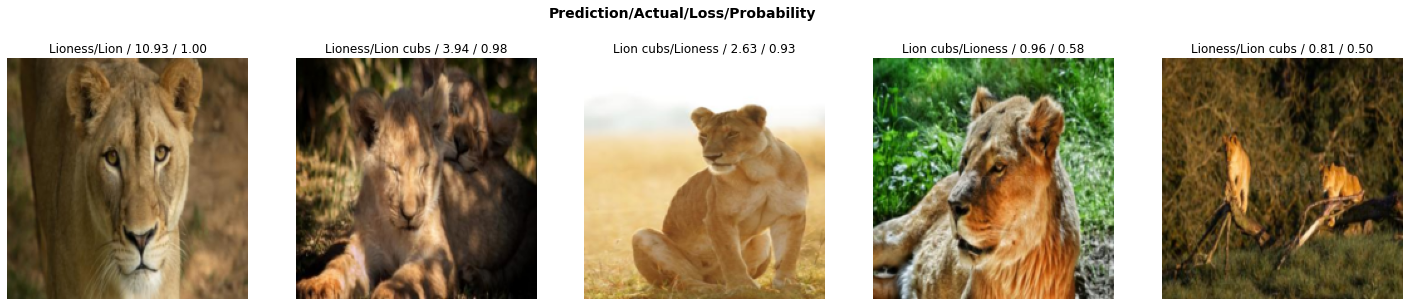

In [175]:
interp.plot_top_losses(5, nrows=1, figsize=(25,5))